In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import pickle

In [99]:
df = pd.read_csv(r'C:\\Users\\jxsha\\credit-risk-xai\\data\\accepted_2007_to_2018Q4.csv.gz', nrows=1500)
df.shape

(1500, 151)

In [100]:
if df['int_rate'].dtype == 'object':
    df['int_rate'] = pd.to_numeric(df['int_rate'].str.rstrip('%'), errors='coerce')

base = df[['loan_amnt', 'int_rate', 'annual_inc']].copy()
base['loan_to_income'] = base['loan_amnt'] / (base['annual_inc'].replace(0, np.nan))
base['loan_to_income'] = base['loan_to_income'].replace([np.inf, -np.inf], np.nan)
base['loan_to_income'] = base['loan_to_income'].fillna(base['loan_to_income'].median())
base['log_annual_inc'] = np.log1p(base['annual_inc'].clip(lower=0))

features = ['loan_amnt', 'int_rate', 'annual_inc', 'loan_to_income', 'log_annual_inc']
df['target'] = (df['loan_status'] == 'Charged Off').astype(int)
df_simple = pd.concat([base[features], df['target']], axis=1).dropna()
df_simple.shape, df_simple['target'].value_counts(normalize=True)

((1500, 6),
 target
 0    0.854667
 1    0.145333
 Name: proportion, dtype: float64)

In [101]:
X = df_simple[features]
y = df_simple['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((900, 5), (600, 5))

In [102]:
pos_rate = y_train.mean()
neg_pos_ratio = (1 - pos_rate) / max(pos_rate, 1e-9)

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=2,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=neg_pos_ratio
)
xgb_model.fit(X_train, y_train)

proba_test = xgb_model.predict_proba(X_test)[:, 1]
prec, rec, th = precision_recall_curve(y_test, proba_test)
f1s = 2*(prec*rec)/(prec+rec+1e-9)
best_idx = int(np.nanargmax(f1s))
best_thresh = float(th[max(best_idx-1, 0)]) if len(th)>0 else 0.5

auc = roc_auc_score(y_test, proba_test)
auc, best_thresh

(np.float64(0.5640922228944008), 0.032896220684051514)

In [103]:
y_pred_050 = (proba_test >= 0.5).astype(int)
y_pred_opt = (proba_test >= best_thresh).astype(int)

cm_050 = confusion_matrix(y_test, y_pred_050)
cm_opt = confusion_matrix(y_test, y_pred_opt)
cm_050, cm_opt

(array([[425,  88],
        [ 69,  18]]),
 array([[165, 348],
        [ 17,  70]]))

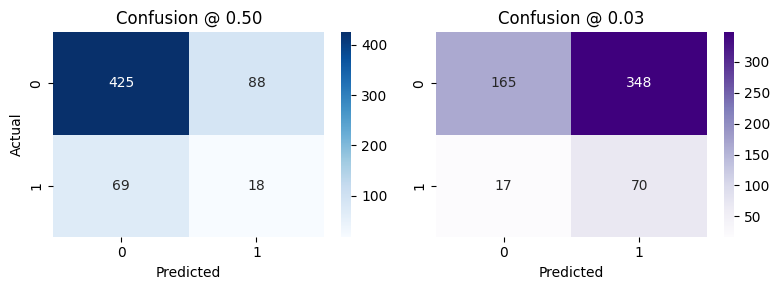

In [104]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
sns.heatmap(cm_050, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion @ 0.50'); plt.ylabel('Actual'); plt.xlabel('Predicted')
plt.subplot(1,2,2)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Purples')
plt.title(f'Confusion @ {best_thresh:.2f}'); plt.ylabel(''); plt.xlabel('Predicted')
plt.tight_layout(); plt.show()

In [105]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
sv = explainer.shap_values(X_test[:200])
if isinstance(sv, list):
    sv = sv[1]
feat_names = list(X_train.columns)
imp = np.abs(sv).mean(0)
pd.DataFrame({'Feature': feat_names, 'SHAP_Importance': imp}).sort_values('SHAP_Importance', ascending=False)

Feature  SHAP_Importance
1        int_rate         1.258940
3  loan_to_income         0.825644
2      annual_inc         0.749508
0       loan_amnt         0.664391
4  log_annual_inc         0.105323

In [106]:
def predict_case(loan_amount, interest_rate, annual_income, threshold=best_thresh):
    row = {
        'loan_amnt': loan_amount,
        'int_rate': interest_rate,
        'annual_inc': annual_income,
        'loan_to_income': loan_amount / (annual_income if annual_income>0 else 1),
        'log_annual_inc': np.log1p(max(annual_income, 0))
    }
    X_one = pd.DataFrame([row])[feat_names]
    p = float(xgb_model.predict_proba(X_one)[0][1])
    yhat = int(p >= threshold)
    print("Pred:", "Bad" if yhat==1 else "Good", "| ProbBad:", f"{p:.1%}", "| Thr:", f"{threshold:.2f}")
    try:
        sv1 = explainer.shap_values(X_one)
        if isinstance(sv1, list):
            sv1 = sv1[1]
        for i, f in enumerate(feat_names):
            print(f"{f}: {sv1[0][i]:+.3f}")
    except:
        pass

In [107]:
predict_case(50000, 22.0, 1000, best_thresh)
predict_case(12000, 11.0, 55000, best_thresh)
predict_case(10000, 20.0, 1500, best_thresh)

Pred: Bad | ProbBad: 10.3% | Thr: 0.03
loan_amnt: -1.528
int_rate: +1.088
annual_inc: -0.750
loan_to_income: -1.191
log_annual_inc: -0.236
Pred: Bad | ProbBad: 71.6% | Thr: 0.03
loan_amnt: +0.483
int_rate: -0.540
annual_inc: +0.229
loan_to_income: +0.310
log_annual_inc: -0.005
Pred: Bad | ProbBad: 21.8% | Thr: 0.03
loan_amnt: -0.696
int_rate: +0.654
annual_inc: -0.198
loan_to_income: -1.267
log_annual_inc: -0.222


In [108]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feat_names, f)
with open('best_threshold.pkl', 'wb') as f:
    pickle.dump(float(best_thresh), f)
"Saved best_model.pkl, feature_names.pkl, best_threshold.pkl"

'Saved best_model.pkl, feature_names.pkl, best_threshold.pkl'